In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df=pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)

In [3]:
import seaborn as sns

In [4]:
df.isnull().sum().values[0]

0

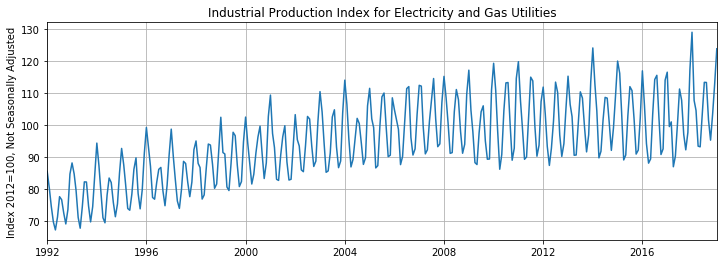

In [5]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

In [6]:
df.head()

,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [7]:
df.shape[0]

325

In [8]:
y=df['IPG2211A2N'].values.astype(float)
test_size=12
window_size=12
train_set=y[:-test_size]
test_set=y[-test_size:]

In [9]:
scaler=MinMaxScaler(feature_range=(-1,1))

In [10]:
train_norm=scaler.fit_transform(train_set.reshape(-1,1))

In [11]:
train_norm=torch.FloatTensor(train_norm).view(-1)

In [12]:
def input_data(seq,ws):
    out=list()
    L=len(seq)
    for i in range(L-ws):
        out.append((seq[i:i+ws],seq[i+ws:i+ws+1]))
    return out

In [13]:
train_data=input_data(train_norm,window_size)

In [14]:
print(f'Length of Training Data is {len(train_data)}')

Length of Training Data is 301


In [15]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size=hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size)
        self.linear=nn.Linear(hidden_size,output_size)
        self.hidden=(torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))
    def forward(self,seq):
        lstm_out,self.hidden=self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred=self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [16]:
model=LSTM()

In [17]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [18]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.001)

In [19]:
train_loss=list()
epochs=50
for i in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred=model(seq)
        loss=criterion(y_pred,y_train)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print(f'Epoch: {i}, Loss: {loss:4.4f}')

Epoch: 0, Loss: 0.7220
Epoch: 10, Loss: 0.1810
Epoch: 20, Loss: 0.1129
Epoch: 30, Loss: 0.1008
Epoch: 40, Loss: 0.1045


In [20]:
future=12
preds=train_norm[-window_size:].tolist()

In [21]:
for f in range(future):
    seq=torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
preds[-window_size:]

[0.24738270044326782,
 -0.007444314658641815,
 -0.31420013308525085,
 -0.18120437860488892,
 0.25557440519332886,
 0.4658076763153076,
 0.19684621691703796,
 -0.07259654253721237,
 -0.23565182089805603,
 0.03289003297686577,
 0.555969774723053,
 0.6264269351959229]

In [23]:
true_predictions=scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))

In [24]:
true_predictions

array([[105.75320509],
       [ 97.91357938],
       [ 88.47639001],
       [ 92.56793789],
       [106.00521879],
       [112.47294026],
       [104.19847544],
       [ 95.90920367],
       [ 90.89288956],
       [ 99.15444542],
       [115.24673213],
       [117.41431145]])

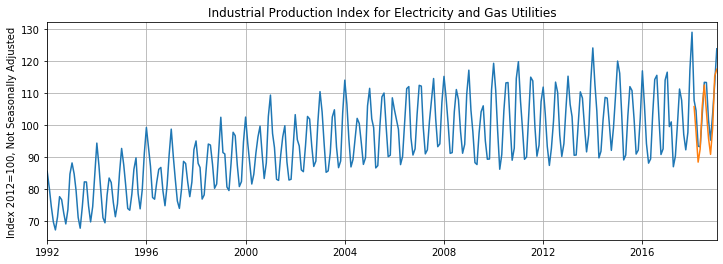

In [25]:
# DON'T WRITE HERE
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

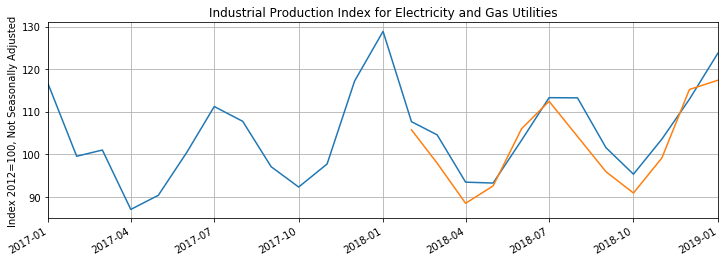

In [26]:
# DON'T WRITE HERE
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()